In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
#make compatible with Python 2 and Python 3
from __future__ import print_function, division, absolute_import

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
data = pd.read_csv('~/Desktop/IEOR290DataX/project/tesla/predict_price/battery operation.csv',parse_dates = True)

In [5]:
print(data.isnull().any().any())

False


In [6]:
display(data[0:10])

,Data Type:,PoolPrices,Charge,Discharge
0,Iteration:,Average,Average,Average
1,7/11/2030 1:00,136.891388,0,0
2,7/11/2030 1:30,127.015976,0,0
3,7/11/2030 2:00,119.54216,0,0
4,7/11/2030 2:30,106.35408,0,0
5,7/11/2030 3:00,99.6936,2.12507153,0
6,7/11/2030 3:30,92.55371,28.1533756,0
7,7/11/2030 4:00,91.18512,30,0
8,7/11/2030 4:30,90.9412,30,0
9,7/11/2030 5:00,91.43035,30,0


In [7]:
data=data.drop(data.index[0])

In [8]:
data['Data Type:']=pd.to_datetime(data['Data Type:'])
data=data.set_index("Data Type:")


In [9]:
data.head()
data = data[0:].convert_objects(convert_numeric=True)

In [10]:
df=data['PoolPrices']


In [11]:
df

Data Type:
2030-07-11 01:00:00    136.891388
2030-07-11 01:30:00    127.015976
2030-07-11 02:00:00    119.542160
2030-07-11 02:30:00    106.354080
2030-07-11 03:00:00     99.693600
2030-07-11 03:30:00     92.553710
2030-07-11 04:00:00     91.185120
2030-07-11 04:30:00     90.941200
2030-07-11 05:00:00     91.430350
2030-07-11 05:30:00     92.210266
2030-07-11 06:00:00     97.887054
2030-07-11 06:30:00    105.619736
2030-07-11 07:00:00    111.945358
2030-07-11 07:30:00    112.791809
2030-07-11 08:00:00    114.356293
2030-07-11 08:30:00    113.750359
2030-07-11 09:00:00    112.782608
2030-07-11 09:30:00    112.667084
2030-07-11 10:00:00    111.885872
2030-07-11 10:30:00    104.440529
2030-07-11 11:00:00     92.701150
2030-07-11 11:30:00     91.907110
2030-07-11 12:00:00     91.820410
2030-07-11 12:30:00     91.820410
2030-07-11 13:00:00     91.784874
2030-07-11 13:30:00     91.784874
2030-07-11 14:00:00     91.780655
2030-07-11 14:30:00     91.820410
2030-07-11 15:00:00     91.820410
203

In [12]:
df1=np.array(df.iloc[:])


In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [14]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

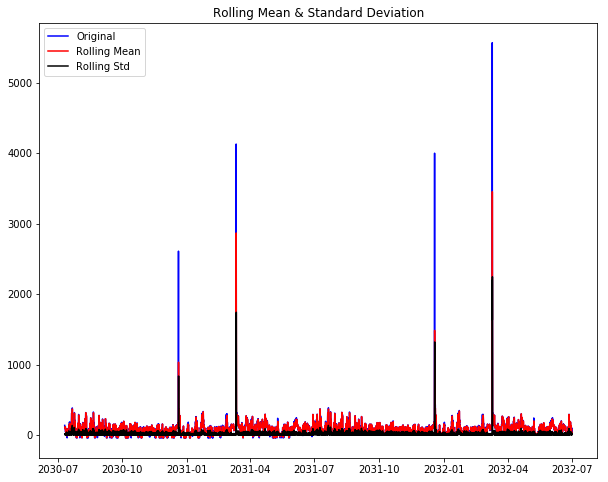

Results of Dickey-Fuller Test:
Test Statistic                -1.616139e+01
p-value                        4.462000e-29
#Lags Used                     4.800000e+01
Number of Observations Used    3.455900e+04
Critical Value (1%)           -3.430539e+00
Critical Value (5%)           -2.861624e+00
Critical Value (10%)          -2.566815e+00
dtype: float64


In [15]:
plt.figure(figsize=(10,8))
test_stationarity(df)


## Determine the parameters that is most suitable for the arima model based on the Autocorrelation function (ACF) and Partial autocorrelation (PACF)

In [16]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
lag_acf = acf(df, nlags=20)
lag_pacf = pacf(df, nlags=20, method='ols')

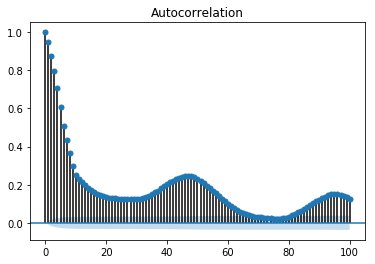

In [17]:
#Plot ACF
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools
import statsmodels.graphics.tsaplots
fig_acf = statsmodels.graphics.tsaplots.plot_acf(df, lags=100)

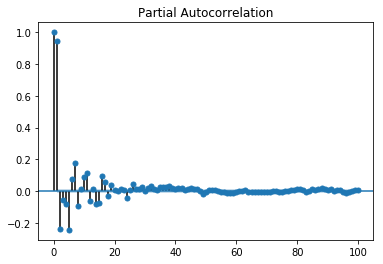

In [18]:
#Plot PACF
fig_pcaf = statsmodels.graphics.tsaplots.plot_pacf(df, lags=100)

In [19]:
X = df.values
size = int(len(X) * 0.995)
train, test = X[0:size], X[size:len(X)]

In [20]:
train

array([136.891388, 127.015976, 119.54216 , ..., 117.615242, 117.541008,
       117.17997 ])

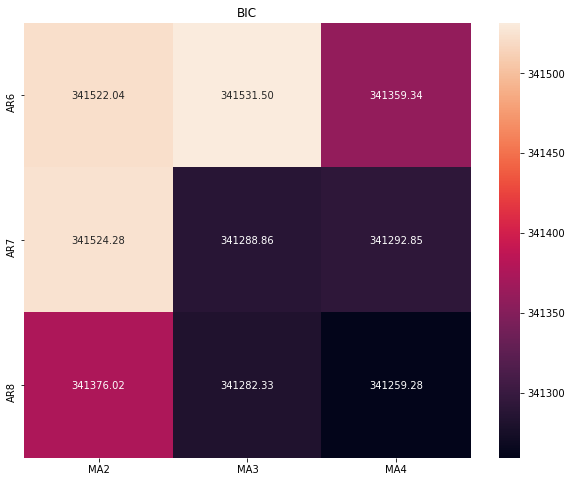

In [21]:
import itertools
import seaborn as sns

p_min = 6
d_min = 0
q_min = 2
p_max = 8
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')
plt.show()

In [22]:
# !pip install pyramid-arima

In [23]:
#import pyramid
#from pyramid.arima.stationarity import ADFTest

#adf_test = ADFTest(alpha=0.05)
#p_val, should_diff = adf_test.is_stationary(df)
#print(p_val, should_diff)

In [24]:
# # Test whether we should difference using differnet criteria
# from pyramid.arima.utils import ndiffs

# # Estimate the number of differences using an ADF test:
# n_adf = ndiffs(df, test='adf')  # -> 0
# print(n_adf)
# # Or a KPSS test (auto_arima default):
# n_kpss = ndiffs(df, test='kpss')  # -> 0
# print(n_kpss)
# # Or a PP test:
# n_pp = ndiffs(df, test='pp')  # -> 0
# print(n_pp)

# #assert n_adf == n_kpss == n_pp == 0

## Since the result generated about the cut-off and the tail off from ACF and PACF is not obvious to detemine the q  and p values , we decided to use the heat map.

In [25]:
# Split to train data set and test data set
price = data["PoolPrices"]
size = int(len(price) * 0.75)
train, test = price[0:size], price[size:len(price)]

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:             PoolPrices   No. Observations:                34608
Model:                     ARMA(8, 4)   Log Likelihood             -171338.247
Method:                       css-mle   S.D. of innovations             34.187
Date:                Mon, 06 May 2019   AIC                         342704.493
Time:                        18:55:44   BIC                         342822.819
Sample:                    07-11-2030   HQIC                        342742.203
                         - 07-01-2032                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               79.3830      4.153     19.114      0.000      71.243      87.523
ar.L1.PoolPrices     1.1742      0.040     29.224      0.000       1.095       1.253
ar.L2.PoolPrices    -0.2271 

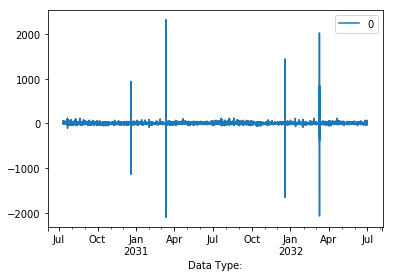

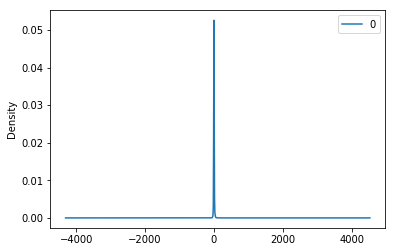

                  0
count  34608.000000
mean       0.000341
std       34.188593
min    -2100.759623
25%       -4.742385
50%       -1.141344
75%        3.520252
max     2318.886386


In [26]:
#Build Arima model on Fridge energy consumption, test on (p,d,q) orders
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df, order=(8,0,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [27]:
# X = df.values
# size = 3000
# train, test = X[0:size], X[size:3500]
# history = [x for x in train]
# predictions = list()

In [28]:
# for t in range(len(test)+1):
#     model = ARIMA(history, order=(2,0,2))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     if t <len(test):
#         obs = test[t]
#         history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))

In [29]:
X = df.values
size = int(len(X) * 0.998+20)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [30]:
# Build rolling arima model & make predictions

for t in range(len(test)+1):
    model = ARIMA(history, order=(8,0,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    if t <len(test):
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))


predicted=113.059490, expected=114.974747
predicted=110.836026, expected=109.875076
predicted=104.266325, expected=99.315765
predicted=94.807721, expected=90.268620
predicted=87.157203, expected=79.273620
predicted=74.882928, expected=73.322760
predicted=69.475244, expected=70.751730
predicted=70.139006, expected=67.508430
predicted=66.761418, expected=64.400345
predicted=64.289505, expected=65.481960
predicted=68.398205, expected=68.003680
predicted=70.637256, expected=71.597000
predicted=73.168120, expected=74.772680
predicted=78.440117, expected=88.791050
predicted=94.150646, expected=89.364716
predicted=91.012767, expected=89.418290
predicted=90.107937, expected=89.647710
predicted=93.663309, expected=89.457280
predicted=89.075573, expected=89.418290
predicted=86.951105, expected=89.356130
predicted=90.538197, expected=89.277214
predicted=89.722741, expected=82.983960
predicted=79.986990, expected=73.088680
predicted=71.784325, expected=36.111220
predicted=31.550981, expected=24.06

In [35]:
error = mean_squared_error(test, predictions[:len(test)])
print('Test MSE: %.3f' % error)

#calculate mean absolute error
print('mean absolute error: %.3f' % mean_absolute_error(test, predictions[:len(test)]))

Test MSE: 125.603
mean absolute error: 5.662


In [36]:
#Define function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [37]:
#Calculate mean absolute percentage error
forecast = np.concatenate(predictions, axis=0)
print('mean absolute percentage error: %.3f' % mean_absolute_percentage_error(test, forecast[:len(forecast)-1]))

mean absolute percentage error: 0.134


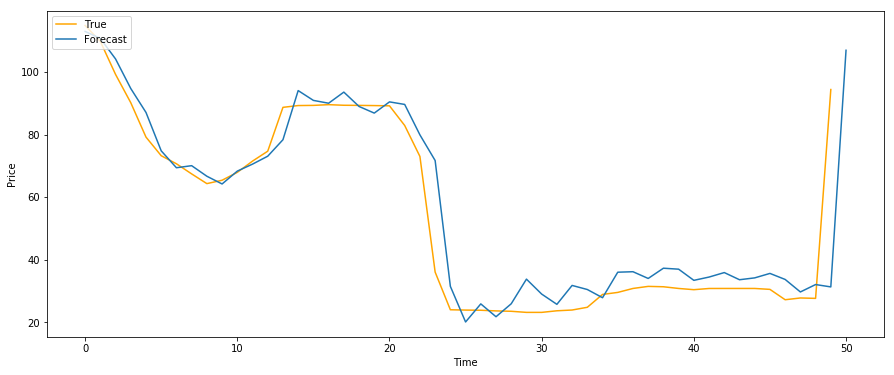

In [38]:
# plot predicted values and true values against time
plt.rcParams['figure.figsize'] = (15, 6)
fig, ax = plt.subplots()

ax.plot(X[size:len(X)],color='orange', linestyle='-', label='True')
ax.plot(predictions, linestyle='-', label = 'Forecast')
ax.set_xlabel('Time') # add xlabel
ax.set_ylabel('Price') # add xlabel

ax.legend(loc=2) # location of legend is an integer,

In [39]:
history = [x for x in train]
forecast_size = 20
true = df.iloc[size:size+forecast_size]
print(true)

Data Type:
2032-06-30 00:00:00    114.974747
2032-06-30 00:30:00    109.875076
2032-06-30 01:00:00     99.315765
2032-06-30 01:30:00     90.268620
2032-06-30 02:00:00     79.273620
2032-06-30 02:30:00     73.322760
2032-06-30 03:00:00     70.751730
2032-06-30 03:30:00     67.508430
2032-06-30 04:00:00     64.400345
2032-06-30 04:30:00     65.481960
2032-06-30 05:00:00     68.003680
2032-06-30 05:30:00     71.597000
2032-06-30 06:00:00     74.772680
2032-06-30 06:30:00     88.791050
2032-06-30 07:00:00     89.364716
2032-06-30 07:30:00     89.418290
2032-06-30 08:00:00     89.647710
2032-06-30 08:30:00     89.457280
2032-06-30 09:00:00     89.418290
2032-06-30 09:30:00     89.356130
Name: PoolPrices, dtype: float64


In [55]:
model = ARIMA(history, order=(8,0,4))
model_fit = model.fit(disp=0)

In [56]:
forecast, stderr, conf_int = model_fit.forecast(steps=forecast_size, alpha=0.2)
forecast = pd.Series(forecast, index=true.index)
print(forecast)

Data Type:
2032-06-30 00:00:00    113.059490
2032-06-30 00:30:00    108.626418
2032-06-30 01:00:00    103.093039
2032-06-30 01:30:00     99.556156
2032-06-30 02:00:00     96.980448
2032-06-30 02:30:00     93.712389
2032-06-30 03:00:00     91.153153
2032-06-30 03:30:00     90.202104
2032-06-30 04:00:00     89.246657
2032-06-30 04:30:00     88.190592
2032-06-30 05:00:00     88.004216
2032-06-30 05:30:00     88.293813
2032-06-30 06:00:00     88.342326
2032-06-30 06:30:00     88.496686
2032-06-30 07:00:00     89.016294
2032-06-30 07:30:00     89.474571
2032-06-30 08:00:00     89.718819
2032-06-30 08:30:00     90.025552
2032-06-30 09:00:00     90.373028
2032-06-30 09:30:00     90.539213
dtype: float64


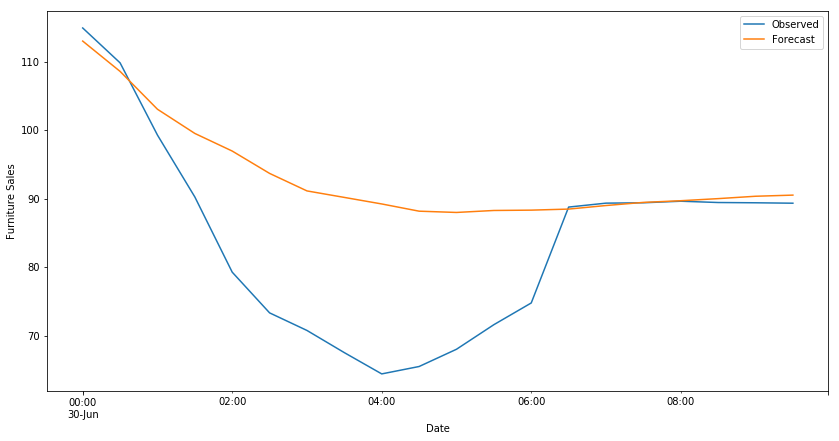

In [57]:
ax = true.plot(label='Observed', figsize=(14, 7))
forecast.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [58]:
pred_ci = pd.DataFrame(conf_int,index=true.index)
pred_ci

,0,1
Data Type:,,
2032-06-30 00:00:00,69.219051,156.899929
2032-06-30 00:30:00,41.686716,175.566121
2032-06-30 01:00:00,18.174603,188.011475
2032-06-30 01:30:00,1.863553,197.248760
2032-06-30 02:00:00,-14.810993,208.771890
2032-06-30 02:30:00,-30.091488,217.516266
2032-06-30 03:00:00,-39.503770,221.810075
2032-06-30 03:30:00,-45.253874,225.658082
2032-06-30 04:00:00,-50.664714,229.158028


In [77]:
before = df.iloc[size-160:size+forecast_size]

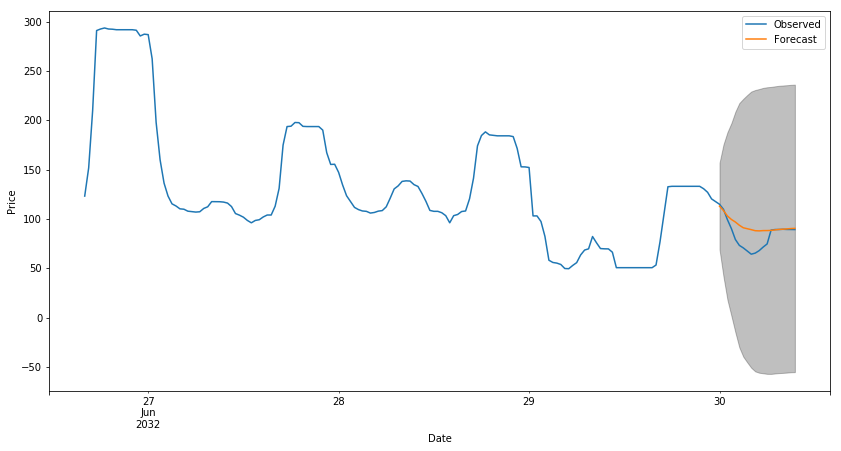

In [78]:
ax = before.plot(label='Observed', figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
forecast.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [61]:
error = mean_squared_error(true, forecast[:len(true)])
print('Test MSE: %.3f' % error)

#calculate mean absolute error
print('Mean absolute error: %.3f' % mean_absolute_error(true, forecast[:len(true)]))

#Calculate mean absolute percentage error
print('Mean absolute percentage error: %.3f' % mean_absolute_percentage_error(true, forecast[:len(true)]))

Test MSE: 188.253
Mean absolute error: 9.936
Mean absolute percentage error: 0.139


In [62]:
plt.figure(figsize=(30,20))

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

In [64]:
! pip install plotly

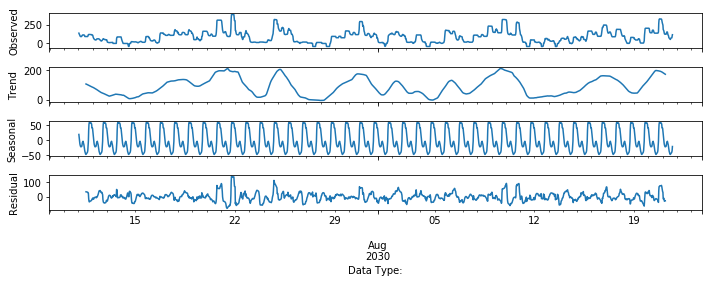

In [65]:
#Get a subset of first 500 times of energy price
small = df[:2000]
#Decompose the subset to study components of data
plt.rcParams['figure.figsize'] = (10, 4)
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
decomfreq=24*60/30
decomfreq=int(decomfreq)
result = seasonal_decompose(small,freq=int(decomfreq))
fig = result.plot()
#Find seasonal component, seanson = 24 hours(1 day)

In [66]:
X = df.values
train = X[0:5000]

In [67]:
# import itertools
# p=range(6,9)
# d=range(0,3)
# q=range(2,5)
# pdq = list(itertools.product(p,d,q))


In [68]:
# import warnings
# aic = []
# warnings.filterwarnings('ignore')
# minlist = []
# for param in pdq:
#     try:
#         model_arima = ARIMA(train,order=param)
#         model_arima_fit = model_arima.fit()
#         print(param,model_arima_fit.aic)
#         minlist.append(model_arima_fit.aic)
#     except:
#         continue

In [69]:
# min(minlist)